In [1]:
import io
import numpy as np
import msgpack
from urllib.request import urlretrieve
from tqdm import tqdm
from multiprocessing.dummy import Pool as ThreadPool
import os
import matplotlib.pyplot as plt

%matplotlib inline

# Building binary format files

We retrieve the models from the Facebook FTP, load them using the [code provided on the MUSE repo](https://github.com/facebookresearch/MUSE/blob/master/demo.ipynb), and serialize the model in a binary format using [msgpack](https://msgpack.org/), a fast and compact serialization format.

Out of the 30 models proposed on the MUSE Github repository (link [here](https://github.com/facebookresearch/MUSE#multilingual-word-embeddings)), only 29 are processed, because the Arabic has a problem at the moment (see [issue 150](https://github.com/facebookresearch/MUSE/issues/150)).

In [2]:
lang_set = {'BG', 'CA', 'CS', 'DA', 'DE', 'EL', 'EN', 'ES', 'ET', 'FI', 'FR', 'HE', 'HR', 'HU', 'ID', 'IT', 'MK', 'NL', 'NO', 'PL', 'PT', 'RO', 'RU', 'SK', 'SL', 'SV', 'TR', 'UK', 'VI'}

Using a threadpool for faster downloading of the models.

In [3]:
def download_language_model(lang):
    urlretrieve('https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.%s.vec' % lang.lower(),
                'wiki.multi.%s.vec' % lang.lower())
    print("%s model downloaded." % lang)

pool = ThreadPool(4)
_ = pool.map(download_language_model,
             [lang for lang in lang_set if not os.path.exists('wiki.multi.%s.vec' % lang.lower())])
pool.close()
pool.join()

VI model downloaded.
NL model downloaded.
PT model downloaded.
NO model downloaded.
CA model downloaded.
HU model downloaded.
HR model downloaded.
RO model downloaded.
IT model downloaded.
UK model downloaded.
SL model downloaded.
BG model downloaded.
DE model downloaded.
HE model downloaded.
PL model downloaded.
SK model downloaded.
MK model downloaded.
FI model downloaded.
ID model downloaded.
EN model downloaded.
SV model downloaded.
DA model downloaded.
RU model downloaded.
CS model downloaded.
FR model downloaded.
ET model downloaded.
EL model downloaded.
TR model downloaded.
ES model downloaded.


This function comes from the [demo notebook](https://github.com/facebookresearch/MUSE/blob/master/demo.ipynb) on the MUSE repository. We use it to load the downloaded models before serializing them in a binary format.

In [45]:
def load_vec(emb_path):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            vectors.append(vect)
            word2id[word] = len(word2id)
    embeddings = np.vstack(vectors)
    return embeddings, word2id

After loading the model, we convert it to `float16` to save space. This incurs a small error of around 10^-5 on average, which is acceptable considering that coefficients have at most a precision of 10^-6 in the text format.

If you aren't confortable with this, you can use a conversion to `float32` instead, 

See section 1.1 below for additional details.

In [5]:
for lang in tqdm(lang_set):
    if os.path.exists("./model_%s.bin" % lang.lower()):
        continue

    embedding, word2id = load_vec("./wiki.multi.%s.vec" % lang.lower())
    
    # Lossy conversion to a smaller binary representation
    embedding = embedding.astype(np.float16)

    ser = (embedding.shape, embedding.tobytes(), word2id)

    with open("./model_%s.bin" % lang.lower(), "wb") as f:
        msgpack.dump(ser, f, use_bin_type=True, encoding="UTF-8")

100%|██████████| 29/29 [06:47<00:00, 14.05s/it]


## Conversion error

In [46]:
emb_text_float64, _ = load_vec("./wiki.multi.en.vec")
emb_text_float32 = emb_text_float64.astype(np.float32)
emb_text_float16 = emb_text_float64.astype(np.float16)

### float16 representation

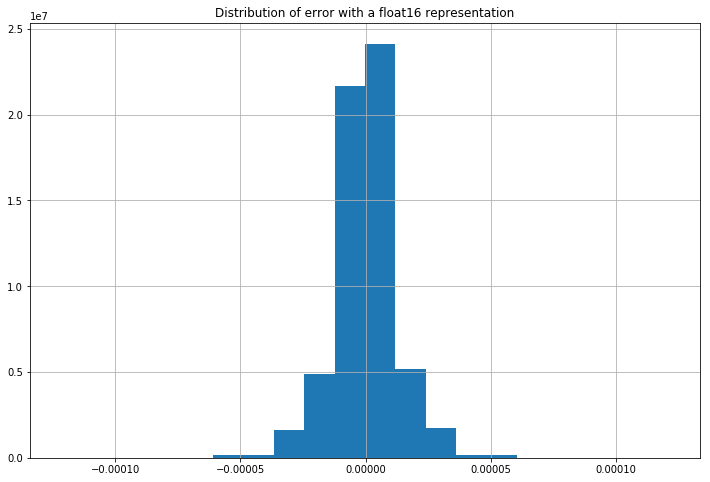

In [59]:
diff = (emb_text_float64 - emb_text_float16).ravel()
plt.figure(figsize=(12, 8))
plt.hist(diff, bins=20)
plt.grid()
plt.title("Distribution of error with a float16 representation");

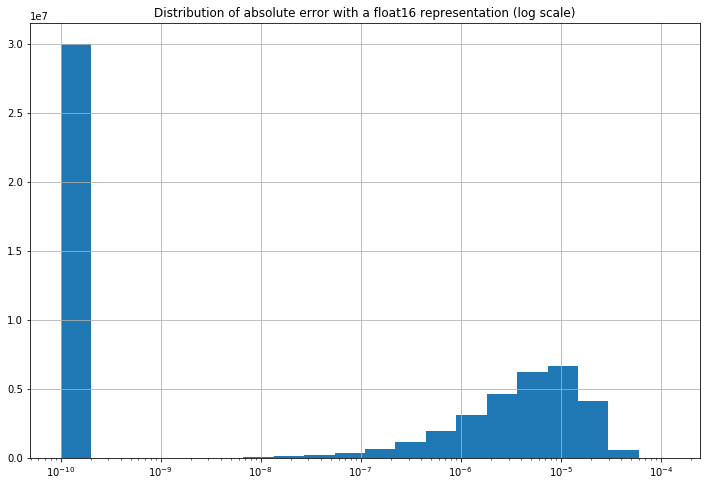

In [64]:
# Clipping the difference at 10^-10 for a log-x histogram
absolute_diff = np.clip(diff, 10**-10, 1)
_, bins = np.histogram(absolute_diff, bins=20)
plt.figure(figsize=(12, 8))
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(absolute_diff, bins=logbins)
plt.xscale('log')
plt.grid()
plt.title("Distribution of absolute error with a float16 representation (log scale)");

### float32 representation

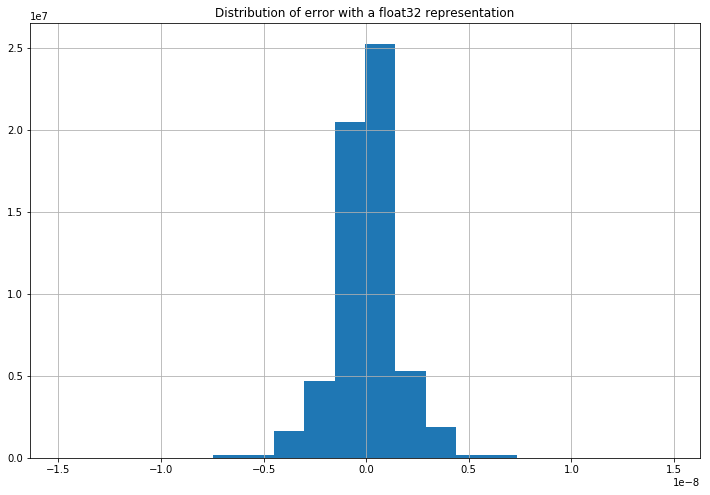

In [65]:
diff = (emb_text_float64 - emb_text_float32).ravel()
plt.figure(figsize=(12, 8))
plt.hist(diff, bins=20)
plt.grid()
plt.title("Distribution of error with a float32 representation");

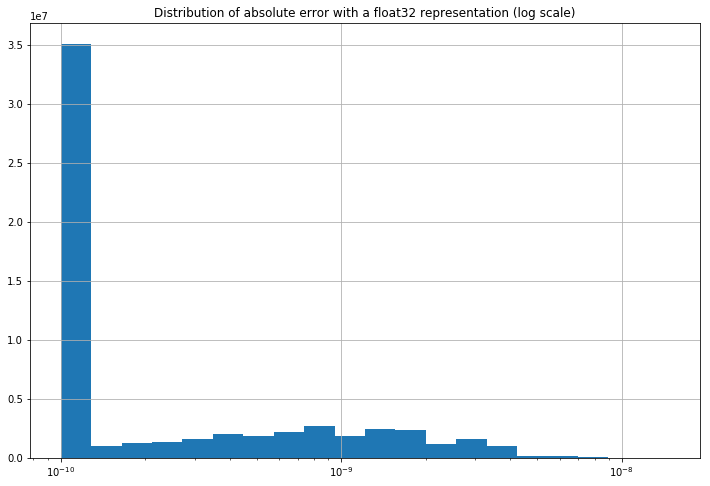

In [66]:
# Clipping the difference at 10^-10 for a log-x histogram
absolute_diff = np.clip(diff, 10**-10, 1)
_, bins = np.histogram(absolute_diff, bins=20)
plt.figure(figsize=(12, 8))
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(absolute_diff, bins=logbins)
plt.xscale('log')
plt.grid()
plt.title("Distribution of absolute error with a float32 representation (log scale)");

# Binary file loading and comparison

In [6]:
def load_vec_bin(filepath):
    with open(filepath, "rb") as f:
        shape, buffer, word2id = msgpack.load(f, encoding="UTF-8")
    embedding = np.ndarray(shape, np.float16, buffer)
    return embedding, word2id

Small test to check that we get the same output than the `load_vec` function.

In [7]:
emb_text, dict_text = load_vec("./wiki.multi.en.vec")
emb_bin, dict_bin = load_vec("./wiki.multi.en.vec")

np.testing.assert_allclose(emb_text, emb_bin)
assert dict_text == dict_bin

The loading is much faster! We see a x100 improvement in loading time.

In [8]:
%timeit _ = load_vec("./wiki.multi.en.vec")

13.6 s ± 31.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit _ = load_vec_bin("./model_en.bin")

97.8 ms ± 373 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


On disk, the files are also about 5x smaller, which also means that your download time should be quite faster too!

In [10]:
!ls -lhatr ./wiki.multi.en.vec | cut -d" " -f 5

600M


In [11]:
!ls -lhatr ./model_en.bin | cut -d" " -f 5

117M
